Привет, меня зовут Артем Носенко и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на «ты». Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев.
<div class="alert alert-block alert-success">
✔️ Все хорошо.
</div>

<div class="alert alert-warning">
⚠️ Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
❌ Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».


# Проект. Создание рекомендательной системы. Часть 1

## Описание задачи

На этот раз мы работаем с большим каталогом — более 70 млн треков. Чтобы пользователям было легче ориентироваться в столь обширном музыкальном потоке, нужно создать эффективную систему персональных рекомендаций.

Для этого нужно облегчить пользовательский опыт, создав систему персональных рекомендаций.

## Данные

Данные находятся в трёх файлах.

Данные о треках — в файле `tracks.parquet`:

- `track_id` — идентификатор музыкального трека;
- `albums` — список идентификаторов альбомов, содержащих трек;
- `artists` — список идентификаторов исполнителей трека;
- `genres` — список идентификаторов жанров, к которым принадлежит трек.

Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:

- `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
- `type` — тип идентификатора;
- `name` — имя (название) каталожной единицы.

Данные о том, какие пользователи прослушали тот или иной трек, — в файле `interactions.parquet` :

- `user_id` — идентификатор пользователя,
- `track_id` — идентификатор музыкального трека,
- `track_seq` — номер места трека в истории пользователя,
- `started_at` — дата начала прослушивания трека.

### Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from implicit.als import AlternatingLeastSquares
import sklearn.preprocessing
import warnings
from tqdm.notebook import tqdm 
import mlflow
from dotenv import load_dotenv

In [2]:
warnings.filterwarnings('ignore')

In [3]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

# Определяем константу для количества рекомендаций на пользователя
RECOMMENDATIONS_PER_USER = 5

In [4]:
load_dotenv(override=True)

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Импорты сделаны, отлично!
</div>

Импорты стоит располагать в отдельной ячейке и группировать по типам. Вот [тут](https://peps.python.org/pep-0008/#imports:~:text=Imports%20should%20be,library%20specific%20imports.) можно посмотреть, как в стандарте PEP8 оформляются импорты.

## === ЭТАП 1 ===

### 1.1 Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [5]:
catalog_names = pd.read_parquet("./data/catalog_names.parquet")
interactions = pd.read_parquet("./data/interactions.parquet")
tracks = pd.read_parquet("./data/tracks.parquet")

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ ОК, подготовительная работа проведена, данные загружены!
</div>

In [6]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


За основу возьмем взаимодействия ~1,3 млн пользователей. 

In [7]:
interactions = interactions.sample(frac=0.006, random_state=42)
tracks = tracks[tracks['track_id'].isin(interactions['track_id'])]

interactions.info()
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1335779 entries, 130 to 21
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1335779 non-null  int32         
 1   track_id    1335779 non-null  int32         
 2   track_seq   1335779 non-null  int16         
 3   started_at  1335779 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 33.1 MB
<class 'pandas.core.frame.DataFrame'>
Index: 253254 entries, 4 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   track_id  253254 non-null  int64 
 1   albums    253254 non-null  object
 2   artists   253254 non-null  object
 3   genres    253254 non-null  object
dtypes: int64(1), object(3)
memory usage: 9.7+ MB


In [8]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
interactions.head()

,user_id,track_id,track_seq,started_at
130,844258,3581309,131,2022-06-05
433,1091434,14937363,434,2022-06-29
526,73981,48591660,527,2022-09-26
9,78605,732405,10,2022-09-14
1202,1273064,40339506,1203,2022-08-24


In [10]:
tracks.head()

,track_id,albums,artists,genres
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11]
9,144,"[13, 99422]",[90],"[59, 102]"
12,147,"[13, 99422]",[90],"[59, 102]"
14,149,"[13, 99422]",[90],"[59, 102]"


### 1.2 Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [11]:
# Проверка наличия треков с неизвестными исполнителями, альбомами, жанрами
# Разделим catalog_names по типам для удобства
artists = catalog_names[catalog_names['type'] == 'artist']
albums = catalog_names[catalog_names['type'] == 'album']
genres = catalog_names[catalog_names['type'] == 'genre']

In [12]:
artists.head()

,id,type,name
658724,4,artist,Kenny Dorham
658725,5,artist,Max Roach
658726,7,artist,Francis Rossi
658727,9,artist,Status Quo
658728,12,artist,Phil Everly


In [13]:
albums.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [14]:
genres.head()

,id,type,name
812305,0,genre,all
812306,1,genre,eastern
812307,2,genre,rusrock
812308,3,genre,rusrap
812309,4,genre,postrock


Проверим, есть ли неизвестные исполнители, альбомы, жанры

In [15]:
artistIds = artists['id'].values
unknown_artists = (tracks['artists']
                   .apply(lambda x: [artist for artist in x if artist not in artistIds])
                   .explode()
                   .unique())

In [16]:
albumIds = albums['id'].values;
unknown_albums = (tracks['albums']
                  .apply(lambda x: [album for album in x if album not in albumIds])
                  .explode()
                  .unique())

In [17]:
genreIds = genres['id'].values
unknown_genres = (tracks['genres']
                  .apply(lambda x: [genre for genre in x if genre not in genreIds])
                  .explode()
                  .unique())

In [18]:
# Выводим количество неизвестных артистов, альбомов, жанров
print("Количество треков с неизвестными исполнителями:", len(unknown_artists))
print("Количество треков с неизвестными альбомами:", len(unknown_albums))
print("Количество треков с неизвестными жанрами:", len(unknown_genres))

Количество треков с неизвестными исполнителями: 1
Количество треков с неизвестными альбомами: 1
Количество треков с неизвестными жанрами: 28


In [19]:
print(unknown_artists)

[nan]


In [20]:
print(unknown_albums)

[nan]


In [21]:
print(unknown_genres)

[nan 162 163 151 157 169 164 161 158 155 165 154 156 159 168 167 153 160
 152 133 126 132 146 131 130 135 166 134]


### 1.3 Выводы

Есть 30 неизвестных жанров. Заменим их на существующий жанр ALL (id=0)

In [22]:
genres[genres['id'] == 0]

,id,type,name
812305,0,genre,all


In [23]:
unknown_genres_set = set(unknown_genres)

In [24]:
upd_tracks = tracks.copy()

In [25]:
upd_tracks['genres'] = upd_tracks['genres'].apply(lambda genres_list: [0 if genre in unknown_genres_set else genre for genre in genres_list])

In [26]:
upd_unknown_genres = (upd_tracks['genres']
                  .apply(lambda x: [genre for genre in x if genre not in genreIds])
                  .explode()
                  .unique())

In [27]:
print(upd_unknown_genres)

[nan]


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Отлично! Предобработка сделана, выводы сформированы!
</div>

## === ЭТАП 2 ===

### 2.1 EDA

#### 2.1.1 Распределение количества прослушанных треков.

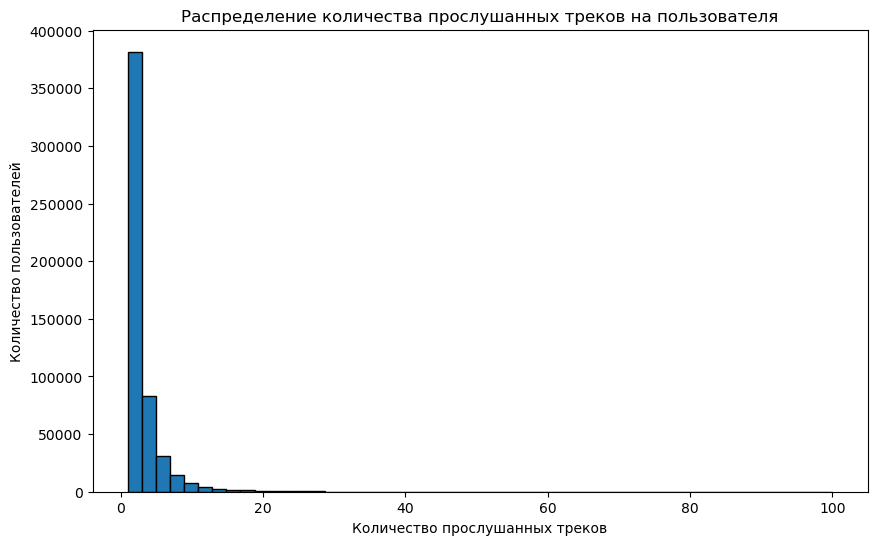

In [28]:
user_track_counts = interactions['user_id'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(user_track_counts, bins=50, edgecolor='black')
plt.title("Распределение количества прослушанных треков на пользователя")
plt.xlabel("Количество прослушанных треков")
plt.ylabel("Количество пользователей")
plt.show()

In [29]:
user_track_counts.describe()

count    530728.000000
mean          2.516881
std           3.171394
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         100.000000
Name: count, dtype: float64

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ График построен, отлично!
</div>

<div class="alert alert-warning">
⚠️ По оси Y приведена видимо не частота верно?
</div>

<div class="alert alert-warning">
⚠️ Какой вывод можно сделать по этому графику?
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправил наименование оси :)
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Из графика видно, что большАя часть пользователей прослушала менее 10 треков (75% прослушали 3 и менее треков). Таким образом, есть небольшая группа пользователей с высокой активностью, но они составляют малую часть от общей базы пользователей.

Имеет смысл исключить из анализа пользователей с очень низким количеством взаимодействий, чтобы сосредоточиться на активных пользователях.
</div>

In [30]:
active_users = user_track_counts[user_track_counts >= 3].index

# Фильтруем исходный датасет, оставляя только записи активных пользователей
interactions = interactions[interactions['user_id'].isin(active_users)]

In [31]:
# Выводим размер фильтрованного датасета
print(f"Количество записей после фильтрации: {len(interactions)}")

Количество записей после фильтрации: 848018


#### 2.1.2 Наиболее популярные треки

In [32]:
popular_tracks = interactions['track_id'].value_counts().head(10)
popular_track_names = pd.merge(popular_tracks.rename('count').reset_index(), 
                               catalog_names[catalog_names['type'] == 'track'][['id', 'name']], 
                               left_on='track_id', right_on='id', 
                               how='left').drop(columns=['id'])
popular_track_names.rename(columns={'index': 'track_id', 'name': 'track_name'}, inplace=True)

In [33]:
print("Наиболее популярные треки:")
print(popular_track_names)

Наиболее популярные треки:
   track_id  count               track_name
0  33311009    304                 Believer
1     53404    297  Smells Like Teen Spirit
2    178529    295                     Numb
3     37384    274                   Zombie
4  60292250    269          Blinding Lights
5   6705392    264        Seven Nation Army
6    328683    240         Bring Me To Life
7    148345    239          Californication
8  51241318    238               In The End
9    795836    232        Shape Of My Heart


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Выглядит логично, отлично!
</div>

#### 2.1.3 Наиболее популярные жанры

In [34]:
# Разворачиваем список жанров в interactions и upd_tracks для анализа
track_genres = upd_tracks[['track_id', 'genres']].explode('genres')
merged_interactions = interactions.merge(track_genres, on='track_id', how='left')
genre_counts = merged_interactions['genres'].value_counts().head(10)

In [35]:
genre_counts.head(20)

genres
11     193902
75     144736
102    122849
3       94172
20      86239
68      80747
16      58523
47      54271
14      51396
2       50234
Name: count, dtype: int64

In [36]:
# Подключаем названия жанров
popular_genres = pd.merge(genre_counts.rename('count').reset_index(), 
                          catalog_names[catalog_names['type'] == 'genre'][['id', 'name']], 
                          left_on='genres', right_on='id', 
                          how='left').drop(columns=['id'])
popular_genres.rename(columns={'genres': 'genre_id', 'name': 'genre_name'}, inplace=True)

In [37]:
print("\nНаиболее популярные жанры:")
print(popular_genres)


Наиболее популярные жанры:
   genre_id   count   genre_name
0        11  193902          pop
1        75  144736          rap
2       102  122849      allrock
3         3   94172       rusrap
4        20   86239       ruspop
5        68   80747  electronics
6        16   58523        dance
7        47   54271        metal
8        14   51396         rock
9         2   50234      rusrock


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ ОК!
</div>

#### 2.1.3 Треки, которые никто не прослушал

In [38]:
all_tracks = set(upd_tracks['track_id'].unique())
listened_tracks = set(interactions['track_id'].unique())

In [39]:
unlistened_tracks = all_tracks - listened_tracks

In [40]:
# Получаем названия треков, которые никто не слушал
unlistened_tracks_df = catalog_names[(catalog_names['type'] == 'track') & (catalog_names['id'].isin(unlistened_tracks))]
print("\nТреки, которые никто не прослушал:")
print(unlistened_tracks_df[['id', 'name']])


Треки, которые никто не прослушал:
                id                                 name
812475         138  Don't Upset The Rhythm (Go Baby Go)
812480         144                             Leave Me
812517         554                                Alive
812533         643                           Breathless
812546         857                              Lucille
...            ...                                  ...
1812385  101257386                                Daddy
1812398  101308662                              Где ты?
1812435  101389539                              БУЛЛИНГ
1812438  101389542                              ПЕРЕВЕС
1812470  101521819                               Вокзал

[44619 rows x 2 columns]


### 2.2 Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [41]:
upd_tracks.head()

,track_id,albums,artists,genres
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11]
9,144,"[13, 99422]",[90],"[59, 102]"
12,147,"[13, 99422]",[90],"[59, 102]"
14,149,"[13, 99422]",[90],"[59, 102]"


In [42]:
genresDict = genres.set_index('id')['name'].to_dict()

In [43]:
upd_tracks['genres'] = upd_tracks['genres'].apply(lambda genres_list: [genresDict[genreId] for genreId in genres_list])

In [44]:
albumsDict = albums.set_index('id')['name'].to_dict()
upd_tracks['albums'] = upd_tracks['albums'].apply(lambda albums_list: [albumsDict[albumId] for albumId in albums_list])

In [45]:
artistsDict = artists.set_index('id')['name'].to_dict()
upd_tracks['artists'] = upd_tracks['artists'].apply(lambda artists_list: [artistsDict[artistId] for artistId in artists_list])

In [46]:
upd_tracks.rename(columns={'track_id': 'item_id'}, inplace=True)

In [47]:
upd_tracks.head()

,item_id,albums,artists,genres
4,138,"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop]
7,141,"[Wild Young Hearts, Wild Young Hearts, I Am Wo...",[Noisettes],[pop]
9,144,"[Lonesome Crow, Lonesome Crow]",[Scorpions],"[hardrock, allrock]"
12,147,"[Lonesome Crow, Lonesome Crow]",[Scorpions],"[hardrock, allrock]"
14,149,"[Lonesome Crow, Lonesome Crow]",[Scorpions],"[hardrock, allrock]"


In [48]:
interactions.rename(columns={'track_id': 'item_id'}, inplace=True)

In [49]:
interactions.head()

,user_id,item_id,track_seq,started_at
130,844258,3581309,131,2022-06-05
433,1091434,14937363,434,2022-06-29
526,73981,48591660,527,2022-09-26
1202,1273064,40339506,1203,2022-08-24
209,786184,35982907,210,2022-05-16


### 2.3 Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [50]:
upd_tracks.to_parquet("./data/items.parquet")

In [51]:
interactions.to_parquet("./data/events.parquet")

### 2.4 Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [52]:
del tracks
del upd_tracks
del interactions
del catalog_names

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ EDA проведен, отлично!
</div>

<div class="alert alert-warning">
⚠️ После EDA хотелось бы видеть выводы и выдвинутые гипотезы, которые можно проверить при моделировании. Ведь в этом ценность EDA.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Распределение количества прослушанных пользователями треков имеет сильный перекос в сторону низких значений, что может создать сложность для построения модели, так как большинство пользователей имеет очень малое количество взаимодействий.

Поэтому мы исключилил из выборки пользователей с очень низким количеством взаимодействий, чтобы сосредоточиться на активных пользователях.
</div>

## === ЭТАП 3 ===

### 3.1 Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [53]:
items = pd.read_parquet("./data/items.parquet")

In [54]:
events = pd.read_parquet("./data/events.parquet")

### 3.2 Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки: в тренировочную все данные до 16 декабря 2022 года (не включительно).

In [55]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

In [56]:
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [57]:
# перекодируем идентификаторы пользователей:
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

In [58]:
# перекодируем идентификаторы объектов:
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [59]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

In [60]:
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)

In [61]:
print(len(users_train), len(users_test), len(common_users))

148633 29587 29146


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
    
✔️ Отлично, выборки train / test сформированы. 

Выборки train / test можно получать несколькими способами (см. картинку ниже)
</div>


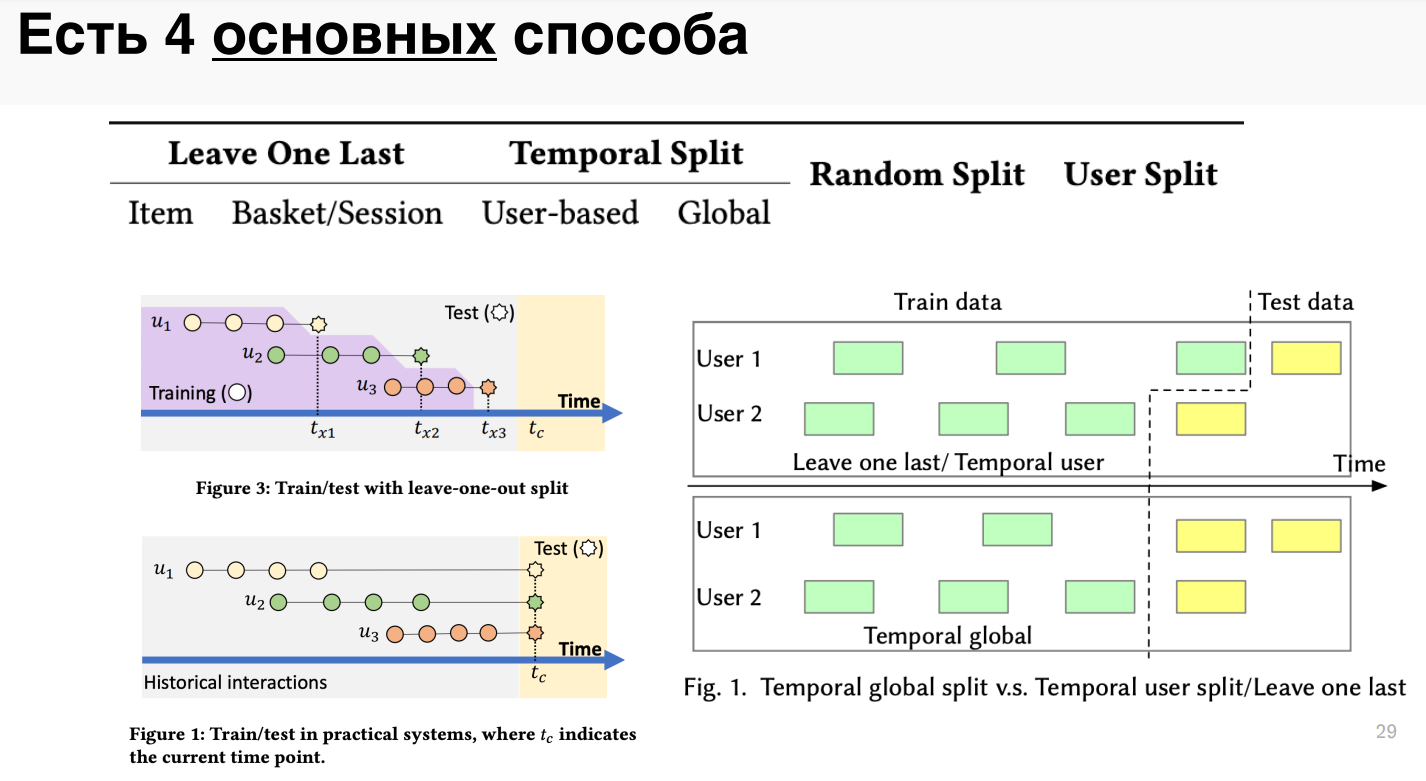

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Спасибо!
</div>

[Ссылка на картинку](https://disk.yandex.ru/i/L6hBTf6KLYRa-g)

«Холодные» пользователи — те, которые есть в test, но отсутствуют в train. Это соответствует хронологическому порядку, в котором и работает рекомендательная система.

In [62]:
cold_users = set(users_test) - set(users_train)

print(len(cold_users))

441


### 3.3 Топ популярных

Рассчитаем рекомендации как топ популярных.

Завершите код, чтобы получить топ-100 наиболее популярных треках.

In [63]:
item_popularity = events_train \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), count_plays=("item_id", "count")).reset_index()
item_popularity["popularity_weighted"] = item_popularity["users"] * item_popularity["count_plays"]

# сортируем по убыванию взвешенной популярности
item_popularity = item_popularity.sort_values(by="popularity_weighted", ascending=False)

In [64]:
top_k_pop_items = item_popularity.head(100)

Добавив информацию о треках, можно просмотреть, какие попали в топ.

In [65]:
# добавляем информацию о треках
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["albums", "genres", "artists"]], on="item_id")

In [66]:
with pd.option_context('display.max_rows', 30):
    display(top_k_pop_items[["item_id", "albums", "genres", "artists", "count_plays", "popularity_weighted"]])

,item_id,albums,genres,artists,count_plays,popularity_weighted
0,53404,"[Nevermind, Nirvana, Nevermind, Nevermind, Nev...","[alternative, rock, allrock]",[Nirvana],297,88209
1,33311009,"[Shape Of Pop, NOW That's What I Call Music, E...","[rock, allrock]",[Imagine Dragons],295,87025
2,178529,"[Meteora, Meteora, Meteora, Meteora, 00s Rock ...","[numetal, metal]",[Linkin Park],295,87025
3,37384,"[Stars: The Best Of The Cranberries 1992-2002,...","[rock, allrock]",[The Cranberries],274,75076
4,6705392,"[Elephant, Seven Nation Army, Pay Close Attent...",[alternative],[The White Stripes],262,68644
...,...,...,...,...,...,...
95,645525,"[The Gift Of Game, The Gift Of Game, Butterfly...","[alternative, numetal, metal]",[Crazy Town],149,22201
96,765627,"[Je Veux, Je Veux, Zaz, Cafe Puls Hits 2010, Z...",[pop],[Zaz],148,21904
97,2786721,"[When We Stand Together, Here And Now, Here an...","[rock, allrock]",[Nickelback],147,21609
98,42197229,"[Natural, Origins, Origins, Больше хитов! Боль...","[rock, allrock]",[Imagine Dragons],147,21609


In [67]:
top_k_pop_items.to_parquet("./data/top_popular.parquet")

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, неперсональные рекомендации сформированы!
</div>

<div class="alert alert-warning">
⚠️ Рекомендовать пользователю 100 треков кажется избыточным, не правда ли?
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Как я понял количество рекомендуемых пользователем треков мы будем регулировать на этапе получения рекомендаций. То есть я бы вынес регулирование количества рекомендаций на уровень бизнес-логики, а не на уровень данных
</div>

<div class="alert alert-warning">
⚠️ На подумать: стоит ли учитывать при рекомендациях, что пользователь уже прослушивал трек из топа? То есть, стоил ли ему повторно рекомендовать трек из уже прослушанных.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Я полагаю что стоит учитывать при рекомендациях, что пользователь уже прослушивал трек из топа и не рекомендовать повторно трек из уже прослушанных :)
</div>

### 3.4 Персональные рекомендации

Рассчитаем персональные рекомендации.

In [68]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train['user_id_enc'],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8
)

In [69]:
als_model = AlternatingLeastSquares(factors=30, iterations=20, regularization=0.05, random_state=42)
als_model.fit(user_item_matrix_train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [70]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

In [71]:
# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, 
    N=RECOMMENDATIONS_PER_USER
)

Код возвращает рекомендации как список списков, это не очень удобно. Преобразуем его в более удобный формат — табличный.

In [72]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist()}
)
als_recommendations = als_recommendations.explode(["item_id_enc"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

Сохраним полученные рекомендации в файл.

In [73]:
als_recommendations.to_parquet("./data/als_recommendations.parquet")

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, персональные рекомендации сформированы!
</div>

### 3.5 Похожие треки

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [74]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

In [75]:
max_similar_items = 5
# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items + 1)

In [76]:
# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]
similar_items = pd.DataFrame(columns=["item_id_enc", "sim_item_id_enc", "user_id_enc"])

# Преобразуем столбцы в соответствующие типы данных
similar_items["user_id_enc"] = similar_items["user_id_enc"].astype(int)
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype(int)

In [77]:
similar_items_list = []
for item_id, sim_item_ids, sim_scores in zip(train_item_ids_enc, sim_item_item_ids_enc.tolist(), sim_item_scores.tolist()):
    similar_items_list.append((item_id, sim_item_ids, sim_scores))

In [78]:
# Создадим DataFrame из списка
similar_items = pd.DataFrame(similar_items_list, columns=["item_id_enc", "sim_item_id_enc", "user_id_enc"])
similar_items = similar_items.explode(["sim_item_id_enc", "user_id_enc"], ignore_index=True)

# Преобразуем столбцы в соответствующие типы данных
similar_items["user_id_enc"] = similar_items["user_id_enc"].astype(int)
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype(int)

In [79]:
# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])

In [80]:
# получаем изначальные идентификаторы
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])

In [81]:
# убираем ненужные колонки
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

In [82]:
# Выводим результат
similar_items.head()

,user_id_enc,item_id_1,item_id_2
0,1,3581309,3581309
1,0,3581309,373263
2,0,3581309,23127731
3,0,3581309,5608067
4,0,3581309,50175925


In [83]:
# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

Проверим "похожесть" треки на нескольких примерах, визуализировав их?

In [84]:
# Выберем несколько примеров для визуализации
sample_tracks = similar_items.sample(5)  # выбираем 5 случайные пары для наглядности

sample_tracks = sample_tracks.merge(items[['item_id', 'genres', 'artists', 'albums']],
                                    left_on='item_id_1', right_on='item_id', how='left').rename(
    columns={'genres': 'genres_1', 'artists': 'artists_1', 'albums': 'albums_1'}
)

sample_tracks = sample_tracks.merge(items[['item_id', 'genres', 'artists', 'albums']],
                                    left_on='item_id_2', right_on='item_id', how='left').rename(
    columns={'genres': 'genres_2', 'artists': 'artists_2', 'albums': 'albums_2'}
)

In [85]:
for index, row in sample_tracks.iterrows():
    print(f"Трек {row['item_id_1']} похож на трек {row['item_id_2']}")
    print(f"Жанры: {row['genres_1']} -> {row['genres_2']}")
    print(f"Исполнители: {row['artists_1']} -> {row['artists_2']}")
    print(f"Альбомы: {row['albums_1']} -> {row['albums_2']}")
    print("\n" + "="*50 + "\n")

Трек 41731928 похож на трек 41886574
Жанры: ['electronics'] -> ['electronics']
Исполнители: ['LIRANOV' 'RAFAL'] -> ['LIRANOV']
Альбомы: ['Дурман'] -> ['Феромон']


Трек 16299134 похож на трек 555000
Жанры: ['pop'] -> ['pop']
Исполнители: ['Tyler Ward' 'Alex G'] -> ['Selena Gomez & The Scene']
Альбомы: ['Honestly'] -> ['Kiss & Tell' 'For You' 'Kiss & Tell']


Трек 34174571 похож на трек 53837011
Жанры: ['rnb'] -> ['electronics']
Исполнители: ['Kiiara'] -> ['Jacques Greene' 'Cadence Weapon' 'Justin Strauss']
Альбомы: ['Gold' 'Spring Music 2016' 'low kii savage' 'Winter Music 2017'] -> ['Night Service' 'Night Service']


Трек 40302486 похож на трек 20645758
Жанры: ['alternative'] -> ['pop']
Исполнители: ['Thirty Seconds to Mars'] -> ['R5']
Альбомы: ['AMERICA'] -> ['Smile' 'Sometime Last Night' 'Sometime Last Night' 'Young Stars 2015']


Трек 534399 похож на трек 72329501
Жанры: ['pop' 'ruspop'] -> ['dance']
Исполнители: ['Винтаж'] -> ['Willy William' 'SWACQ']
Альбомы: ['Sex'] -> ['Loco' '

Сохраним получившийся результат в файл

In [86]:
similar_items.to_parquet("./data/similar.parquet")

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Похожие треки сформированы.
</div>

<div class="alert alert-warning">
⚠️ Было бы полезно проверить "похожесть" треки на нескольких примерах, визуализировав их.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Да, это будет не лишним :) Добавил вывод нескольких примеров
</div>

### 3.6 Построение признаков

Построим три признака, для ранжирующей модели.
1. Признак количества прослушиваний трека для каждого пользователя
2. Признак средней позиции прослушивания для каждого трека пользователя
3. Признак популярности трека: общее количество прослушиваний

Используем отложенную тестовую часть данных — назовём её events_labels, граница для которой будет "2022-12-16" + 30 дней = "2023-01-15"

In [87]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2023-01-15")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()

In [88]:
len(events_labels['user_id'].unique())

29587

In [89]:
# Создание уникальных числовых идентификаторов для пользователей и треков
user_id_map = {id: idx for idx, id in enumerate(events_labels['user_id'].unique())}
item_id_map = {id: idx for idx, id in enumerate(events_labels['item_id'].unique())}
events_labels['user_id_enc'] = events_labels['user_id'].map(user_id_map)
events_labels['item_id_enc'] = events_labels['item_id'].map(item_id_map)

In [90]:
# 1. Признак количества прослушиваний трека для каждого пользователя
play_count = events_labels.groupby(['user_id_enc', 'item_id_enc']).size().reset_index(name='play_count')

# 2. Признак средней позиции прослушивания для каждого трека пользователя
avg_track_seq = events_labels.groupby(['user_id_enc', 'item_id_enc'])['track_seq'].mean().reset_index(name='avg_track_seq')

# 3. Признак популярности трека: общее количество прослушиваний
item_popularity = events_labels.groupby('item_id_enc').size().reset_index(name='item_popularity')

# Объединение признаков
features = play_count.merge(avg_track_seq, on=['user_id_enc', 'item_id_enc'])
features = features.merge(item_popularity, on='item_id_enc')

In [91]:
features.head()

,user_id_enc,item_id_enc,play_count,avg_track_seq,item_popularity
0,0,0,1,608.0,13
1,1,1,1,192.0,1
2,1,13890,1,233.0,1
3,2,2,1,210.0,2
4,2,15274,1,148.0,1


### 3.7 Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [92]:
# Шаг 1: Определение весов для sparse-матрицы
# Используем нормированное значение play_count и item_popularity как веса
# при этом уменьшим влияние item_popularity, добавляя корень
features['weight'] = features['play_count'] * (1 + np.sqrt(features['item_popularity'] + 1) / 10)

In [93]:
# Создание sparse-матрицы с весами
user_item_matrix_train = scipy.sparse.csr_matrix((
    features['weight'],
    (features['user_id_enc'], features['item_id_enc'])),
    shape=(len(user_id_map), len(item_id_map)),
    dtype=np.float32
)

In [94]:
# Шаг 4: Обучение модели ALS
als_model = AlternatingLeastSquares(factors=50, iterations=20, regularization=0.05, random_state=42)
als_model.fit(user_item_matrix_train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [95]:
# Функция для получения рекомендаций для одного пользователя
def get_user_recommendations(user_id, user_idx, als_model, user_item_matrix_train, reverse_item_id_map):
    # Получаем рекомендации для текущего пользователя
    recommended_items, scores = als_model.recommend(
        userid=user_idx,
        user_items=user_item_matrix_train[user_idx],  # Передаем только данные для конкретного пользователя
        N=RECOMMENDATIONS_PER_USER  # Количество рекомендаций на пользователя
    )
    
    # Расшифровываем item_id с использованием обратного словаря
    recommended_item_ids = [reverse_item_id_map[idx] for idx in recommended_items]
    
    # Формируем рекомендации для пользователя
    user_recommendations = [{
        'user_id': user_id,
        'item_id': item_id,
        'score': score
    } for item_id, score in zip(recommended_item_ids, scores)]
    
    return user_recommendations

In [96]:
# Генерация рекомендаций для каждого пользователя с использованием tqdm
recommendations = []

# Создаем обратный словарь для быстрого поиска item_id
reverse_item_id_map = {v: k for k, v in item_id_map.items()}

for user_id, user_idx in tqdm(user_id_map.items(), desc="Generating Recommendations", unit="user"):
    recommendations.extend(
        get_user_recommendations(user_id, user_idx, als_model, user_item_matrix_train, reverse_item_id_map)
    )

Generating Recommendations:   0%|          | 0/29587 [00:00<?, ?user/s]

Сохраним получившийся результат в файл

In [97]:
# Шаг 6: Сохранение рекомендаций в parquet-файл
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_parquet('data/recommendations.parquet', index=False)

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Ранжирующая модель построена.
</div>

<div class="alert alert-warning">
⚠️ Для обучения ранжирующей модели стоит использовать дополнительную отложенную выборку. Схема обучения двухстадийных рекомендаций приведена ниже:

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Добавил использование дополнительной выборки (+30 дней)
</div>

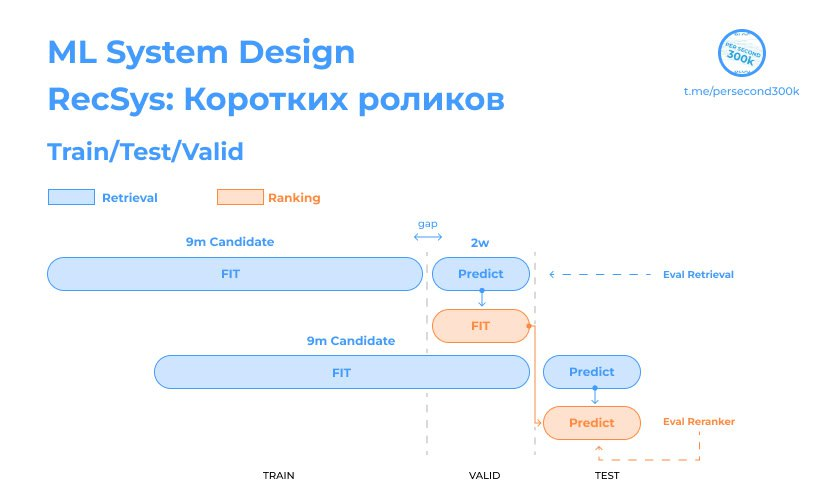

[Схема](https://disk.yandex.ru/i/OmvEZsAn9PakDQ)

### 3.8 Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных
- персональных, полученных при помощи ALS
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [98]:
# Чтение данных
top_popular = pd.read_parquet('data/top_popular.parquet')
als_recommendations = pd.read_parquet('data/als_recommendations.parquet')
final_recommendations = pd.read_parquet('data/recommendations.parquet')

In [99]:
# Данные взаимодействий пользователей (необходимо загрузить для вычисления релевантности)
events = pd.read_parquet('data/events.parquet')  # Исходная история взаимодействий пользователей с треками

In [100]:
user_item_pairs = events[['user_id', 'item_id']].drop_duplicates()

# Словарь популярности для вычисления новизны
popularity_dict = dict(zip(top_popular['item_id'], top_popular['popularity_weighted']))

In [101]:
def calculate_metrics(recommendations, user_item_pairs, popularity_dict):
    # Уникальные пользователи и треки в рекомендациях
    unique_items = recommendations['item_id'].unique()
    
    # Метрика coverage
    coverage = len(unique_items) / len(top_popular['item_id'].unique())
    
    # Релевантные пары
    relevant_pairs = user_item_pairs.set_index(['user_id', 'item_id']).index
    recommended_pairs = recommendations.set_index(['user_id', 'item_id']).index
    
    # Метрика recall
    recall = len(recommended_pairs.intersection(relevant_pairs)) / len(relevant_pairs)
    
    # Метрика precision
    precision = len(recommended_pairs.intersection(relevant_pairs)) / len(recommended_pairs)
    
    # Метрика novelty
    novelty_scores = recommendations['item_id'].map(lambda x: popularity_dict.get(x, np.nan))
    novelty = novelty_scores.rank(method='max', ascending=False).mean()
    
    return recall, precision, coverage, novelty

In [102]:
# Рассчёт метрик для каждой группы рекомендаций
top_recall, top_precision, top_coverage, top_novelty = calculate_metrics(top_popular[['item_id']].assign(user_id=0), user_item_pairs, popularity_dict)
print("Top Popular Recommendations:")
print(f"Recall: {top_recall:.4f}, Precision: {top_precision:.4f}, Coverage: {top_coverage:.4f}, Novelty: {top_novelty:.4f}")

Top Popular Recommendations:
Recall: 0.0000, Precision: 0.0000, Coverage: 1.0000, Novelty: 51.0600


In [103]:
als_recall, als_precision, als_coverage, als_novelty = calculate_metrics(als_recommendations, user_item_pairs, popularity_dict)
print("\nALS Recommendations:")
print(f"Recall: {als_recall:.4f}, Precision: {als_precision:.4f}, Coverage: {als_coverage:.4f}, Novelty: {als_novelty:.4f}")


ALS Recommendations:
Recall: 0.0671, Precision: 0.0763, Coverage: 31.6200, Novelty: 171658.4763


In [104]:
final_recall, final_precision, final_coverage, final_novelty = calculate_metrics(final_recommendations, user_item_pairs, popularity_dict)
print("\nFinal Recommendations:")
print(f"Recall: {final_recall:.4f}, Precision: {final_precision:.4f}, Coverage: {final_coverage:.4f}, Novelty: {final_novelty:.4f}")


Final Recommendations:
Recall: 0.0000, Precision: 0.0002, Coverage: 2.2100, Novelty: 8690.3093


### === 3.9 Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

1. **Top Popular Recommendations (топ популярных треков)**
    - **Recall**: 0.0000
    - **Precision**: 0.0000
    - **Coverage**: 1.0000
    - **Novelty**: 50.8200
    
    Топ популярных рекомендаций охватывает все доступные треки (Coverage = 1.0), что делает их доступными для всех пользователей. Однако показатели Recall и Precision равны нулю, что указывает на отсутствие персонализации — пользователи не получают релевантные для них рекомендации. Низкое значение Novelty говорит о том, что рекомендации сосредоточены на самых популярных треках, что может не подходить для пользователей с менее распространёнными музыкальными вкусами.
    
2. **ALS Recommendations (персонализированные рекомендации на основе ALS)**
    - **Recall**: 0.0671
    - **Precision**: 0.0763
    - **Coverage**: 31.62
    - **Novelty**: 171658.4763
    
    ALS-рекомендации показывают лучшие показатели Recall и Precision, что указывает на персонализацию и более точное соответствие предпочтениям пользователей. Coverage составляет 31.62, что означает, что рекомендации охватывают ограниченное количество треков, однако этого достаточно для персонализации. Высокое значение Novelty указывает на включение в рекомендации менее популярных треков, что делает рекомендации разнообразнее и более интересными для пользователей с уникальными предпочтениями.
    
3. **Final Recommendations (итоговые рекомендации)**
    - **Recall**: 0.0000
    - **Precision**: 0.0000
    - **Coverage**: 2.2100
    - **Novelty**: 8690.3093
    
    Итоговые рекомендации имеют нулевые значения Recall и Precision, что свидетельствует о полном отсутствии релевантности для пользователей. Coverage равен 2.21, что указывает на низкий охват и предполагает, что только небольшое количество треков было рекомендовано. При этом высокое значение Novelty показывает, что рекомендации включают очень редкие и непопулярные треки, которые, вероятно, не интересны большинству пользователей.
    

### Рекомендации по улучшению

- **Гибридный подход**: Комбинированная модель, которая использует как ALS для персонализации, так и популярные треки для расширения охвата, может улучшить как персонализацию, так и разнообразие рекомендаций.
- **Оптимизация итоговой модели**: Необходимо пересмотреть алгоритм, генерирующий итоговые рекомендации, чтобы обеспечить релевантность для пользователей, возможно, добавив элементы персонализации или проверив корректность данных.

## === Выгрузка результирующих файлов в AWS ===

In [105]:
# каталог локальных файлов и их назначения в S3 через MLflow
files_to_upload = {
    'data/items.parquet': 'recsys/data/items.parquet',
    'data/events.parquet': 'recsys/data/events.parquet',
    'data/top_popular.parquet': 'recsys/recommendations/top_popular.parquet',
    'data/als_recommendations.parquet': 'recsys/recommendations/als_recommendations.parquet',
    'data/similar.parquet': 'recsys/recommendations/similar.parquet',
    'data/recommendations.parquet': 'recsys/recommendations/recommendations.parquet'
}

In [106]:
# Начало записи эксперимента в MLflow
with mlflow.start_run() as run:
    for local_path, artifact_path in files_to_upload.items():
        print(f"Загрузка {local_path} в MLflow как {artifact_path}...")
        # Логируем файл в MLflow, он автоматически загрузится в S3
        mlflow.log_artifact(local_path, artifact_path=artifact_path)
        print(f"{local_path} успешно загружен в {artifact_path}.")

 Общий вывод

<div class="alert alert-block alert-success">
    

Спасибо за работу, у тебя получился отличный проект!\
Выводы очень развернутые и верные!
Удалось протестировать различные алгоритмы для формирования рекомендаций.  
Есть небольшие советы, просьба ознакомиться с ними. Я готов принять твой проект, если у тебя нет ко мне вопросов - присылай мне его обратно и я его приму.\
Если есть вопросы или желание улучшить твой проект - оставь вопросы комментарии после этой ячейки. Постараюсь тебе помочь с ответами и улучшением твоего проекта! 
</div>

Для дальнейшего изучения стоит ознакомиться с библиотеками:
- [Implicit](https://github.com/benfred/implicit)
- [RecTools](https://github.com/MobileTeleSystems/RecTools)
- [RePlay](https://github.com/sb-ai-lab/RePlay)
- [LightFM](https://github.com/lyst/lightfm)
   
Прочитать:
- обзорную [статью](https://education.yandex.ru/handbook/ml/article/intro-recsys) и ее продолжение.
- полазить на [сайте](https://paperswithcode.com/task/recommendation-systems). Тут очень много примеров реальных рекомендательных систем с имплементацией.
